In [183]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
from pathlib import Path
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
from modules import preprocess_data
since2019 = [Path(os.getcwd(), 'data', f) for f in os.listdir('data') if f.startswith(('2019'))]
trips = preprocess_data.master_data(since2019)

In trips(start) but not in stations: [32031.0, 31008.0, 32051.0, 0.0]
In stations but not in trips(start) [31325.0, 32901.0]
In trips(end) but not in stations: [0.0, 32051.0, 31008.0, 32031.0]
In stations but not in start [31718.0, 31325.0, 32901.0]


In [185]:
def print_unique_values(df, show_limit = 20):
    for col in df.columns:
        if df[col].dtypes == 'O':
            unique_values = df[col].unique()
            if len(unique_values) > show_limit:
                print("%s : %s unique values" % (col, len(unique_values)))
            else:
                print("%s : \n%s" % (col, df[col].value_counts()))
            print('---------------------')

print_unique_values(trips)

start_station : 648 unique values
---------------------
end_station : 647 unique values
---------------------
bike_number : 6053 unique values
---------------------
member_type : 
Member    2955802
Casual     440863
Name: member_type, dtype: int64
---------------------
date : 365 unique values
---------------------
holiday : 
False    3335505
True       61160
Name: holiday, dtype: int64
---------------------
weekend : 
False    2996883
True      399782
Name: weekend, dtype: int64
---------------------


In [194]:
# sample for scripting
df = trips.sample(200000)

In [216]:
df['duration_m'] = df['duration']/60

# Explaratory Data Analysis

    * Basic facts
        - Number of trips
        - Number of stations
        - Number of bikes
        - Most popular routes
        - Most popular stations
    * Number of trips, duration by:
        - Rider type
        - Time of the trip
            - Month
            - Hour
    * Stations
        - locations
    * Understanding demand
        - 
    * Over time:
        - Usage over time
        - Station expansion over time

## Basic Facts

### Number of trips 

Total number of trips in 2019: 200,000


trips
year   month       
2019.0 1.0     8896
       2.0     9182
       3.0    14972
       4.0    20330
       5.0    19896
       6.0    20684
       7.0    21230
       8.0    21109
       9.0    21114
       10.0   19925
       11.0   13250
       12.0    9412

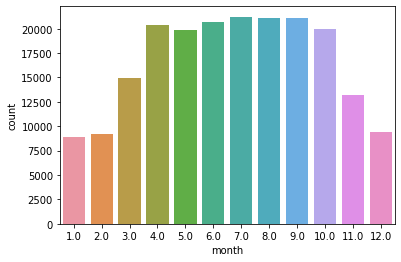

In [197]:
print("Total number of trips in 2019: {:,}".format(df.shape[0]))
sns.countplot(data=df, x='month')
df.groupby(['year', 'month']).size().rename('trips').to_frame()

More rides during warmer months

### Number of stations in use

In [198]:
print("Number of stations in use > 0: {:,}".format(len(df.station_id.unique())))

Number of stations in use > 0: 574


### Number of bikes in use

In [199]:
print("Number of bikes in use> 0: {:,}".format(len(df.bike_number.unique())))

Number of bikes in use> 0: 5,924


### Most popular routes

In [200]:
popular_routes = df.groupby(['start_station', 'end_station']).size().rename('trips').to_frame()
popular_routes.sort_values('trips', ascending=False).head(20)

,,trips
start_station,end_station,
Smithsonian-National Mall / Jefferson Dr & 12th St SW,Smithsonian-National Mall / Jefferson Dr & 12th St SW,312
Columbus Circle / Union Station,6th & H St NE,267
6th & H St NE,Columbus Circle / Union Station,223
Columbus Circle / Union Station,8th & F St NE,216
4th St & Madison Dr NW,4th St & Madison Dr NW,210
Jefferson Dr & 14th St SW,Jefferson Dr & 14th St SW,198
17th St & Independence Ave SW,Lincoln Memorial,197
Lincoln Memorial,Jefferson Memorial,191
8th & F St NE,Columbus Circle / Union Station,182


>Mostly around the mall and downtown

## Most popular stations by either starting or ending a trip

In [428]:
start = df.groupby(['start_station_id', 'start_station']).size().rename('start').astype(int)
end = df.groupby(['end_station_id', 'end_station']).size().rename('end').astype(int)

start.index.levels[0].name = 'id'
start.index.levels[1].name = 'station'
end.index.levels[0].name = 'id'
end.index.levels[1].name = 'station'

s = pd.merge(start, end, 'outer', left_index=True, right_index=True)

# a peak at stations_use indicates that some station id has multiple station names
# probably slightly different versions of the station names have been recorded over time in trips data
s1 = s.droplevel(1, axis=0)
s1 = s1.groupby(s1.index).sum()

s2 = s.reset_index('station')[['station']]
s2 = s2.groupby(s2.index).apply(lambda x: x.iloc[0,]) # pick the value from the first row
stations_use = pd.concat([s2, s1], axis=1)

# some start values and some end values (for different indices) will be NaN because
# some stations only started trips or ended trips. Replace with 0.
stations_use['start'] = stations_use['start'].fillna(0)
stations_use['end'] = stations_use['end'].fillna(0)
stations_use['usage'] = stations_use['start'] + stations_use['end']

stations_use = stations_use.sort_values('usage', ascending=False)
stations_use.head(20)

,station,start,end,usage
id,,,,
31623.0,Columbus Circle / Union Station,3415.0,3789.0,7204.0
31201.0,15th & P St NW,2021.0,2288.0,4309.0
31258.0,Lincoln Memorial,1975.0,2119.0,4094.0
31289.0,Henry Bacon Dr & Lincoln Memorial Circle NW,2034.0,1992.0,4026.0
31288.0,4th St & Madison Dr NW,1946.0,1965.0,3911.0
31248.0,Smithsonian-National Mall / Jefferson Dr & 12t...,1835.0,2035.0,3870.0
31247.0,Jefferson Dr & 14th St SW,1869.0,1990.0,3859.0
31200.0,Massachusetts Ave & Dupont Circle NW,1718.0,2128.0,3846.0
31229.0,New Hampshire Ave & T St NW,2037.0,1785.0,3822.0


# Trips and Duration

### Trips by Member type

[Text(0, 0.5, 'Percent')]

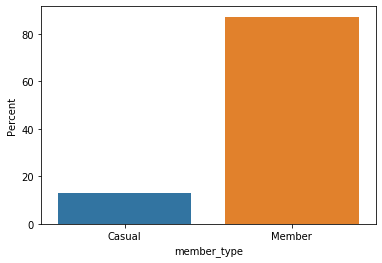

In [214]:
df_member = df.groupby('member_type').apply(lambda x: len(x)/len(df)*100)
df_member
ax = sns.barplot(x=df_member.index, y=df_member.values)
ax.set(ylabel="Percent")

> \>80% of the trips are taken by members

## Duration by Member Type

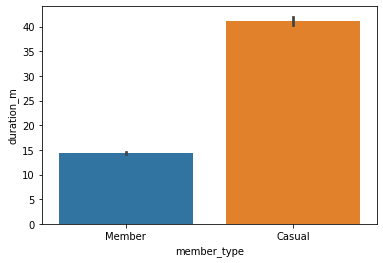

In [219]:
sns.barplot(x='member_type', y='duration_m', data=df)

> The average trip duration in minute shows that casual riders have much longer trips than members, 40 mins vs 15 mins

Capital Bikeshare has a pricing scheme where the first 30 mins is free for members and a some price for casual riders, and the price for an additional 30 min block goes up exponentially, starting at \\$2 and capping at \\$8 after an hour and a half. For instance, for memebrs who pay a monthly fee, the first 30 mins is \\$0, the second 30 mins \\$2, the next 30 mins \\$4, and \\$8 for every additional 30 mins beyond that. The inconvenience notwithstanding, it's most economical to return the bike to a station within 30 minutes and check the same bike out if the destination is more than 30 minutes away 

Let's break duration to 30 min blocks

In [224]:
cutoffs = [0, 30, 60, 90, np.Inf]
df['duration_m_cat'] = pd.cut(df.duration_m, cutoffs, right = False)

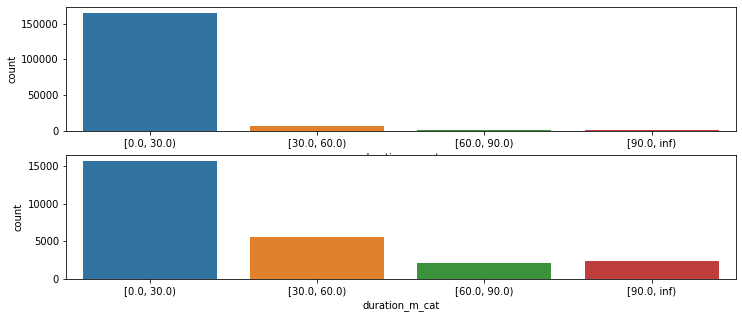

In [225]:
fig, ax = plt.subplots(2, 1, figsize=(12, 5))
sns.countplot(x='duration_m_cat', data=df.query('member_type=="Member"'), ax=ax[0])
sns.countplot(x='duration_m_cat', data=df.query('member_type=="Casual"'), ax=ax[1])

> A considerable share of casual trips are over 1 hour, indicating either casual riders are not price sensitive or don't understand the incremental pricing scheme

## By Trip Start Time

Because members and casual riders clearly display different usage, I'll analyze them separately. Looking at the trips by time further shows that members and casual riders have distinctive usage patterns.

### Hour

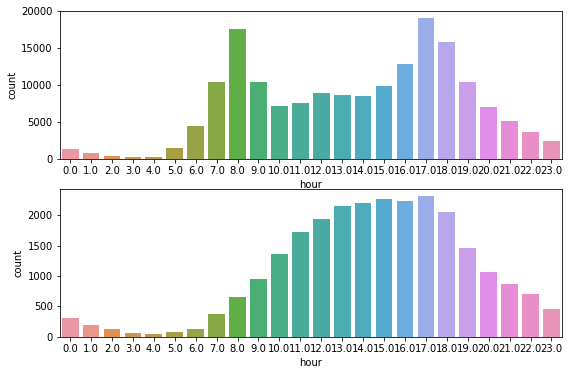

In [229]:
figsize, ax = plt.subplots(2, 1, figsize=(9, 6))
sns.countplot(x='hour', data=df.query('member_type=="Member"'), ax=ax[0])
sns.countplot(x='hour', data=df.query('member_type=="Casual"'), ax=ax[1])

> Member usage peak during commute times while casual usage is normally distributed during the day

### Month

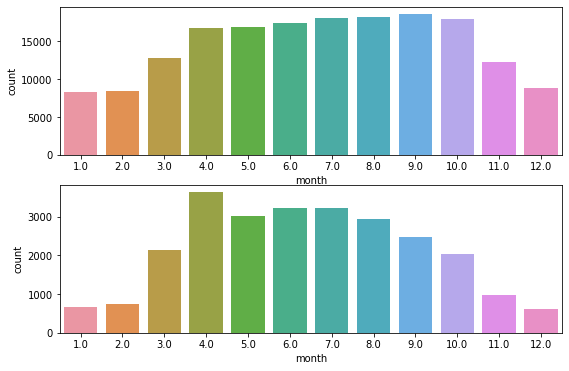

In [230]:
figsize, ax = plt.subplots(2, 1, figsize=(9, 6))
sns.countplot(x='month', data=df.query('member_type=="Member"'), ax=ax[0])
sns.countplot(x='month', data=df.query('member_type=="Casual"'), ax=ax[1])

> Members use the bikes more or less consistently during the warm months (April through October) while casual riders peak in April (cherry blossoms!) and in summer months 

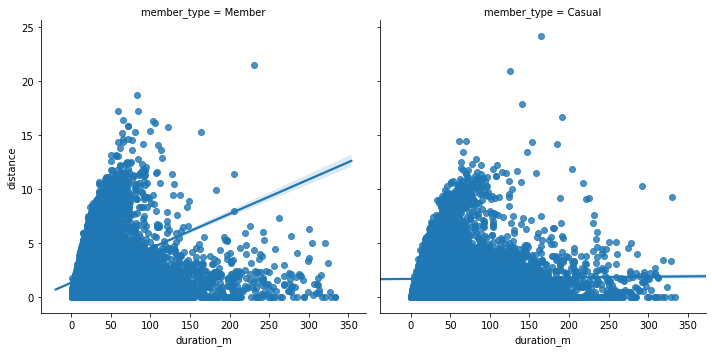

In [235]:
sns.lmplot(x='duration_m', y='distance', col = 'member_type', data = df.query('duration < 20000'))

# Stations

In [429]:
# Get latitude and longitude from stations data
stations_use = pd.merge(stations_use, stations, how='left', left_index=True, right_on='station_id')

In [385]:
stations_use.shape

(574, 8)

In [386]:
stations_use.head()

,station,start,end,usage,station_id,latitude,longitude,capacity
460,Eads St & 15th St S,86.0,81.0,167.0,31000.0,38.858971,-77.053230,15.0
461,18th & Eads St.,109.0,111.0,220.0,31001.0,38.857250,-77.053320,11.0
462,Crystal Dr & 20th St S,338.0,332.0,670.0,31002.0,38.856425,-77.049232,16.0
463,Crystal Dr & 15th St S,229.0,239.0,468.0,31003.0,38.860170,-77.049593,11.0
464,Aurora Hills Cmty Ctr / 18th St & S Hayes St,121.0,105.0,226.0,31004.0,38.857866,-77.059490,11.0


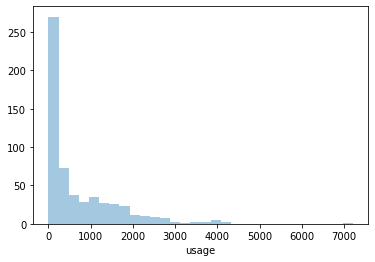

In [391]:
sns.distplot(a=stations_use.usage, kde=False)

> The usage distribution is heavily left-skewed, indicating many are underutilized and few get disporportionate amount of use.

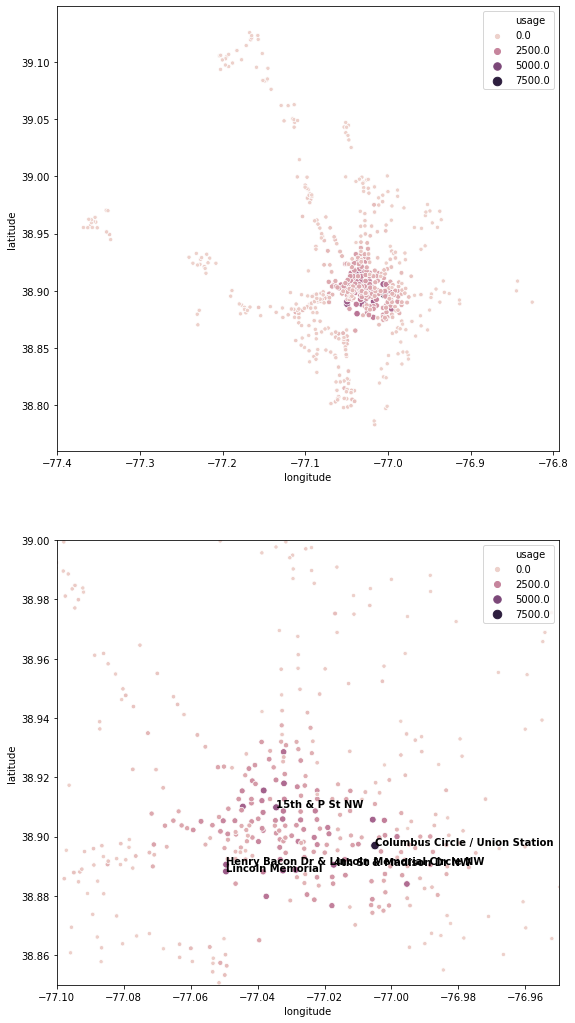

In [437]:
fig, ax = plt.subplots(2, 1, figsize=(9, 18))
g1 = sns.scatterplot(x='longitude', y='latitude', size='usage', hue='usage', data=stations_use, s=20, ax=ax[0])
ax[1].set(xlim=(-77.1, -76.95), ylim=(38.85, 39))

g2 = sns.scatterplot(x='longitude', y='latitude', size='usage', hue='usage', data=stations_use, s=200, ax=ax[1]) # why doesn't the size work??
for i in range(5):
    x_coor = stations_use.iloc[i, ].longitude
    y_coor = stations_use.iloc[i, ].latitude
    name = stations_use.iloc[i, ].station
    g2.text(x_coor, y_coor, name, horizontalalignment='left', size='medium', color='black', weight='semibold')

In [234]:
stations.shape

(576, 9)

## Bike Usage

In [444]:
df.groupby('bike_number').size().to_frame()

,0
bike_number,
21054,6
51020,1
51033,11
51045,7
65005,4
65009,13
65012,12
65033,13
65038,5


In [ ]:
stations_use.capacity.sum()